<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project3_tsunami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Tsunami
In this project, we will use Dedalus to model the propagation of Tsunami waves. Tsunami typically have wavelengths larger than 100km and periods of about 1 hour. Since their wavelength is much larger than the depth of the ocean, Tsunami can be modelled using the shallow water equations.

Here, we will use Dedalus to solve an initial value problem for the shallow water equations. We will generate a Tsunami using a localized disturbance to the water height.

Student tasks are in [Section 1.3]( #section1pt3 ), [Section 2.3]( #section2pt3 ), and [Section 3.3]( #section3pt3 ).

## 1.  1D shallow water equations
Let's start by solving the shallow water equations in 1D with periodic boundary conditions in our spatial variable, $x$. The script below solves the following equations:

$$ \partial_t u + g \partial_x(h) = - u\partial_x u$$
$$ \partial_t h + \partial_x(Hu) = -\partial_x(hu)$$

In these equations, $g$ is the constant gravitational acceleration, $u$ is the velocity in the $x$ direction, $H$ is the resting height, and $h$ is the height of the free surface relative to $H$. Note that the terms on the right hand side are nonlinear in our dependent variables, and we will use an explicit timestepping method for these terms. Recall that Dedalus uses explicit timestepping for terms on the right hand side of the inputted equation.

Because we are interested in an application to Tsunami, we will solve the equations using dimensional variables. It is convenient to define simulation units at the start of the script so that we can be explicit about the units.

We will start with the following initial conditions:
$$ h=e^{-(x-x_1)^2/w_1^2} $$
$$ u=0 $$
where $x_1$ is the center and $w_1=100$ km is the width of the Gaussian perturbation.

To see how the waves change as they approach shallow water, we will set the resting water depth to include a localized seamount using the form:
$$ H=H_0-(H_0-H_{min})e^{(-(x-x_2)^2/w_2^2)} $$
where $x_2$ is the location of the seamount, $H_0=4$ km is the depth of the ocean away from the seamount, and $H_{min}$ is the minimum water depth above the seamount. Note that since $H\ll w$, the shallow water approximation is appropriate here.

### 1.1  Dedalus script to solve the 1D shallow water equations

The script below solves the 1D shallow water equations with the initial conditions given above.

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
        else:
          print("See website for installation instructions:")
          print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size
Nx = 512 # The number of gridpoints in x
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
w1 = 20 * kilometer # Width of the initial perturbation
x1 = 200 * kilometer # Center of the initial perturbation
x2 = 500 * kilometer # Center of the seamount
w2 = 100 * kilometer # Width of the seamount
H_min = 100 * meter # minimum depth above the seamount

timestep = 60 * second # Specify the timestep
stop_sim_time = 100 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(0, Lx))
x = dist.local_grid(x_basis)

# Specify the Fields and set the initial conditions
u = dist.Field(name='u', bases=x_basis)
h = dist.Field(name='h', bases=x_basis)
H = dist.Field(name='H', bases=x_basis)
h.change_scales(1)
H.change_scales(1)
u.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-(x-x2)**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2.0/w1**2.0)  # Initialize the height with a Gaussian function with width set above
u['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u)")
problem.add_equation("dt(h) + dx(H*u) = - dx(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.0e+00/s


2024-12-26 14:20:25,622 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.0e+00/s


INFO:__main__:Starting main loop


2024-12-26 14:20:25,632 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-12-26 14:20:26,063 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 100


2024-12-26 14:20:26,075 solvers 0/1 INFO :: Final iteration: 100


INFO:solvers:Final sim time: 6000.0


2024-12-26 14:20:26,085 solvers 0/1 INFO :: Final sim time: 6000.0


INFO:solvers:Setup time (init - iter 0): 0.5924 sec


2024-12-26 14:20:26,097 solvers 0/1 INFO :: Setup time (init - iter 0): 0.5924 sec


INFO:solvers:Warmup time (iter 0-10): 0.07834 sec


2024-12-26 14:20:26,114 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.07834 sec


INFO:solvers:Run time (iter 10-end): 0.3597 sec


2024-12-26 14:20:26,125 solvers 0/1 INFO :: Run time (iter 10-end): 0.3597 sec


INFO:solvers:CPU time (iter 10-end): 9.991e-05 cpu-hr


2024-12-26 14:20:26,163 solvers 0/1 INFO :: CPU time (iter 10-end): 9.991e-05 cpu-hr


INFO:solvers:Speed: 5.115e+05 mode-stages/cpu-sec


2024-12-26 14:20:26,176 solvers 0/1 INFO :: Speed: 5.115e+05 mode-stages/cpu-sec


### 1.2  Plotting
The code below will make a movie of the height.

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-26 14:20:26,554 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp6e3d85lx/temp.m4v


2024-12-26 14:20:26,564 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp6e3d85lx/temp.m4v


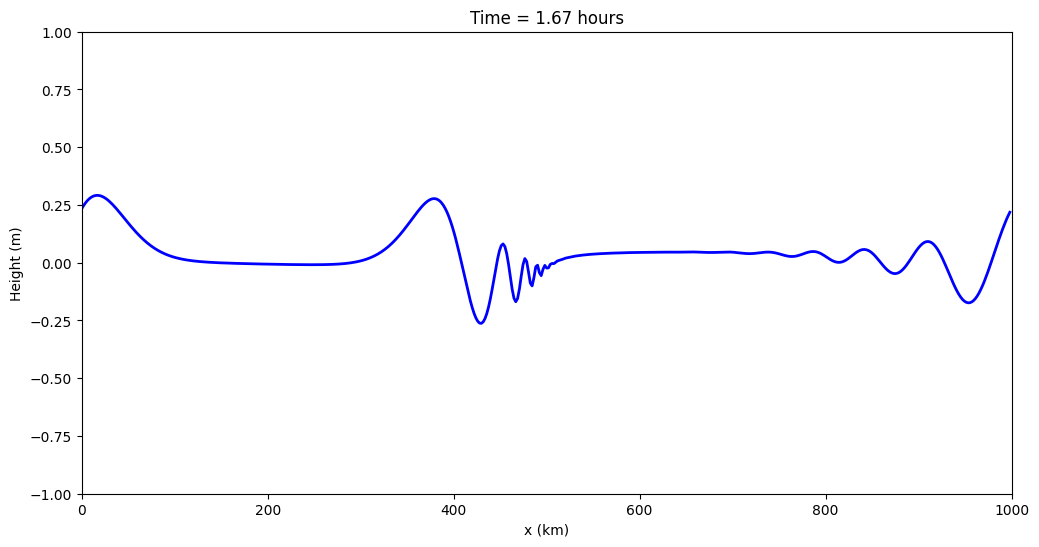

In [2]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Specify the axis limits and labels
plt.xlim((0, Lx / (1*kilometer)))
plt.ylim((-1, 1))
plt.xlabel('x (km)')
plt.ylabel('Height (m)')

# Create objects that will change during the animation
txt_title = plt.title('')
height, = plt.plot([], [], 'b', lw=2)

# Define an animation function
def drawframe(n):
    height.set_data(x/(1*kilometer), h_save[n,:])
    txt_title.set_text('Time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


### 1.3 Student investigation
<a id='section1pt3'></a>
In the cells below, provide an expression for the expected wave speed and state any assumptions that are necessary to arrive at this. Then plot the wave speed from the output above and compare this with the expected value.

To analyze the wave speed, we rely on the shallow water wave speed formula:  
$$c(x) = \sqrt{g \cdot H(x)}$$  
where $c(x)$ is the wave speed, $g$ is the gravitational acceleration, and $H(x)$ is the static water depth. This formula is derived under the assumptions of the shallow water equations, where the wavelength is much larger than the water depth, making the contribution of dynamic surface elevation negligible for calculating wave speed. The static water depth $H(x)$ is used to calculate the expected wave speed because the shallow water wave speed is theoretically dependent only on the static depth.

For the simulated wave speed, we used h_save, which is the dynamic water height output from the simulation. This incorporates both the static water depth $H(x)$ and the dynamic surface height $h(x,t)$.
and the wave speed is calculated as:  
$$c_\text{simulated}(x,t) = \sqrt{g \cdot \big(H(x) + h(x,t)\big)}$$

We calculated:
1. Expected Wave Speed using the static depth $H(x)$:  
   $$c_\text{expected}(x) = \sqrt{g \cdot H(x)}$$
2. Simulated Wave Speed using the dynamic depth from h_save:  
   $$c_\text{simulated}(x,t) = \sqrt{g \cdot \big(H(x) + h(x,t)\big)}$$

Dynamic wave speeds were plotted over the spatial domain for multiple time steps. The simulated wave speed was computed for each time step using h_save, while the expected wave speed was calculated using only the static depth $H(x)$.

The plots showed that the simulated wave speed and the expected wave speed are nearly identical across the domain. Further analysis revealed that the dynamic water height, $h(x,t)$, varied by less than 1% relative to the static depth $H(x)$. This confirms that the dynamic variations in surface height have a negligible impact on the wave speed, and the shallow water wave speed can be accurately modeled using only the static water depth.

Maximum percentage difference between simulated and expected speeds: 0.03%


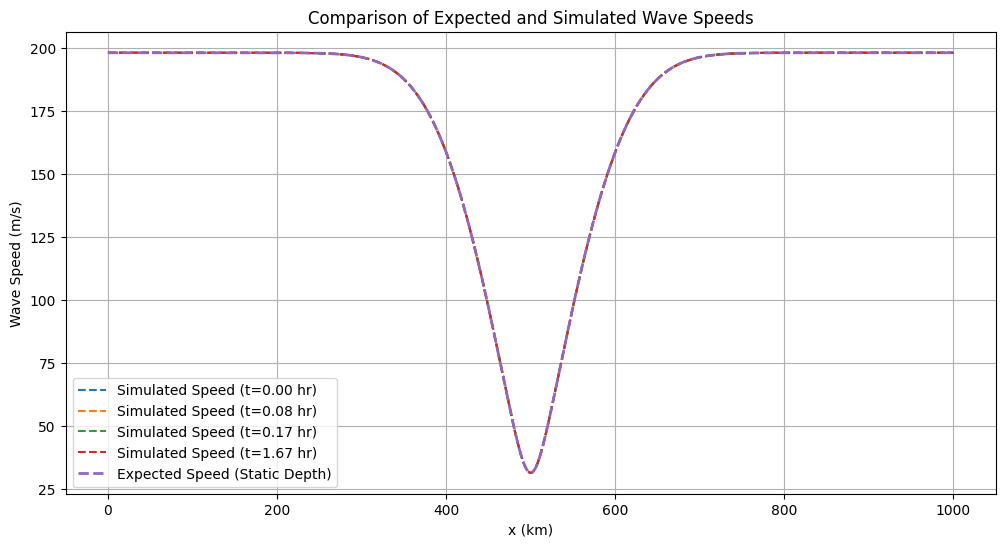

The percentage difference is less than 1%, indicating that the expected and simulated wave speeds are effectively identical.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

g = 9.81
kilometer = 1000
hour = 3600

x_coords = np.linspace(0, 1000, h_save.shape[1])
H_static = H0 - (H0 - H_min) * np.exp(-((x_coords * kilometer - x2) ** 2.0) / w2 ** 2.0)

expected_wave_speed = np.sqrt(g * H_static)

time_steps_to_plot = [0, 5, 10, len(t_save) - 1]
plt.figure(figsize=(12, 6))

for t_idx in time_steps_to_plot:
    simulated_wave_speed = np.sqrt(g * (H_static + h_save[t_idx, :]))
    plt.plot(x_coords, simulated_wave_speed, label=f'Simulated Speed (t={t_save[t_idx]/hour:.2f} hr)', linestyle='--')

plt.plot(x_coords, expected_wave_speed, label='Expected Speed (Static Depth)', linestyle='--', linewidth=2)

percentage_difference = np.max(np.abs(expected_wave_speed - simulated_wave_speed) / expected_wave_speed) * 100
print(f'Maximum percentage difference between simulated and expected speeds: {percentage_difference:.2f}%')

plt.xlabel('x (km)')
plt.ylabel('Wave Speed (m/s)')
plt.title('Comparison of Expected and Simulated Wave Speeds')
plt.legend()
plt.grid()
plt.show()

if percentage_difference < 1:
    print("The percentage difference is less than 1%, indicating that the expected and simulated wave speeds are effectively identical.")


## 2.  2D Shallow water equations

Now, let's see how things change if we move to two dimensions. The script below solves the 2D shallow water equations:

$$ \partial_t u + g \partial_x(h) = - u*\partial_x u - v*\partial_y u$$
$$ \partial_t u + g \partial_y(h) = - u*\partial_x v - v*\partial_y v$$
$$ \partial_t h + H (\partial_x(u) + \partial_y(v)) = -\partial_x(h*u) - \partial_y(h*v)$$

We will solve these equations in a square domain with periodic boundary conditions. We will again initialize with a Gaussian height disturbance and with no water motion, but this time in 2D:

$$ h=e^{-(x^2+y^2)/w^2} $$
$$ u=0 $$
$$ v=0 $$

### 2.1  Dedalus script to solve the 2D shallow water equations

In [4]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Reference ocean depth
width = 100 * kilometer # Set the width of the initial Gaussian

timestep = 60 * second # Specify the timestep
stop_sim_time = 30 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))

# Initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
h['g'] = np.exp(-(x**2+y**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = 0
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + H*(dx(u) + dy(v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing


INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 6.8e+01/s


2024-12-26 14:20:43,862 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 6.8e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+01/s


2024-12-26 14:20:43,903 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 5.9e+01/s


2024-12-26 14:20:43,983 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 5.9e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 6.3e+01/s


2024-12-26 14:20:44,037 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 6.3e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 6.6e+01/s


2024-12-26 14:20:44,091 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 6.6e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 6.7e+01/s


2024-12-26 14:20:44,144 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 6.7e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 6.8e+01/s


2024-12-26 14:20:44,198 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 6.8e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 6.9e+01/s


2024-12-26 14:20:44,251 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 6.9e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.0e+01/s


2024-12-26 14:20:44,304 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.0e+01/s


INFO:__main__:Starting main loop


2024-12-26 14:20:44,314 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-12-26 14:20:45,110 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 30


2024-12-26 14:20:45,116 solvers 0/1 INFO :: Final iteration: 30


INFO:solvers:Final sim time: 1800.0


2024-12-26 14:20:45,121 solvers 0/1 INFO :: Final sim time: 1800.0


INFO:solvers:Setup time (init - iter 0): 0.7835 sec


2024-12-26 14:20:45,127 solvers 0/1 INFO :: Setup time (init - iter 0): 0.7835 sec


INFO:solvers:Warmup time (iter 0-10): 0.2175 sec


2024-12-26 14:20:45,130 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.2175 sec


INFO:solvers:Run time (iter 10-end): 0.2934 sec


2024-12-26 14:20:45,133 solvers 0/1 INFO :: Run time (iter 10-end): 0.2934 sec


INFO:solvers:CPU time (iter 10-end): 8.15e-05 cpu-hr


2024-12-26 14:20:45,136 solvers 0/1 INFO :: CPU time (iter 10-end): 8.15e-05 cpu-hr


INFO:solvers:Speed: 1.623e+06 mode-stages/cpu-sec


2024-12-26 14:20:45,138 solvers 0/1 INFO :: Speed: 1.623e+06 mode-stages/cpu-sec


### 2.2  Plotting
The code below will make a movie of the height as a function of x and y

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-26 14:20:45,240 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp3w_cnmku/temp.m4v


2024-12-26 14:20:45,244 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp3w_cnmku/temp.m4v


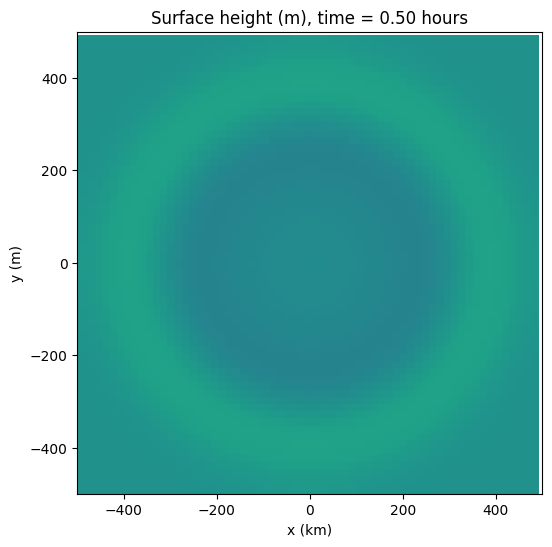

In [5]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:], vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 2.3 Student investigation
<a id='section2pt3'></a>
Notice how the amplitude of the Tsunami wave decreases with distance from the source location. In the cells below, provide an expression for the expected wave amplitude as a function of distance from the origin (x=0, y=0) and explain clearly the reasoning behind this expression. Then, make a plot or plots comparing your prediction for the wave amplitude compared with the results from the simulation.

Try out several different possible initial conditions for the surface height, $h$. How does the shape of the resulting waves change?

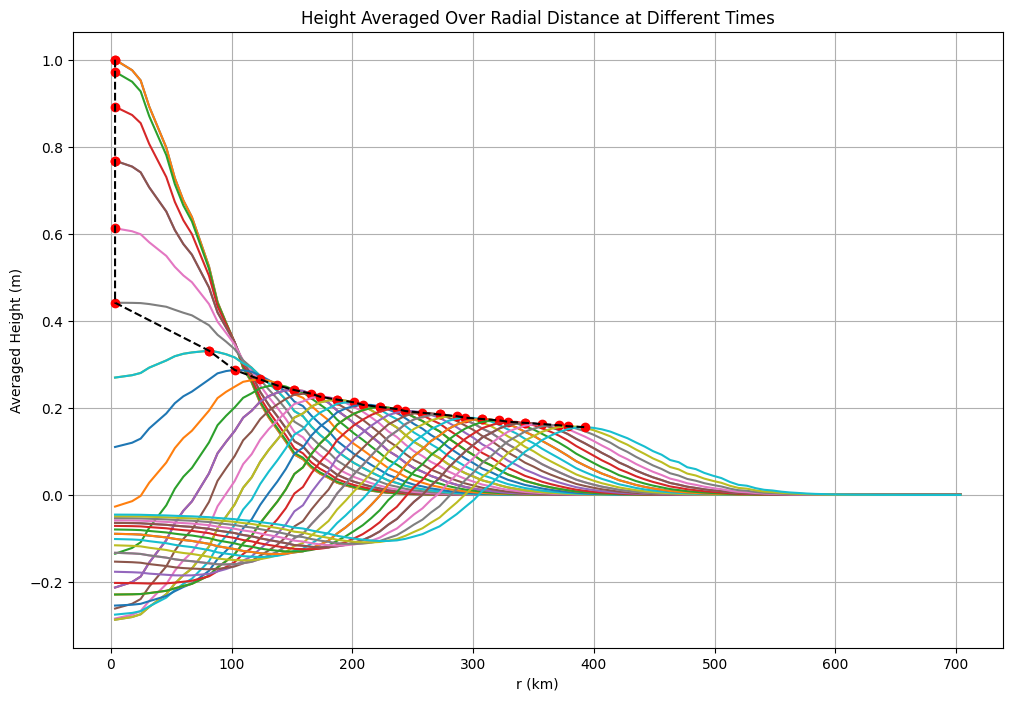

In [6]:
import numpy as np
import matplotlib.pyplot as plt

time_indices = np.linspace(0, len(h_save) - 1, 40, dtype=int)

fig, ax = plt.subplots(figsize=(12, 8))

r = np.sqrt(x**2 + y**2)
num_bins = 100
r_bins = np.linspace(r.min(), r.max(), num_bins + 1)
r_mid = 0.5 * (r_bins[:-1] + r_bins[1:])
indices_r = np.digitize(r, r_bins)

max_amplitudes = []

for index in time_indices:
    final_h = h_save[index, :, :]

    averaged_h = np.zeros(num_bins)

    for i in range(1, num_bins + 1):
        mask = indices_r == i
        if np.any(mask):
            averaged_h[i - 1] = np.mean(final_h[mask])

    condition = np.logical_not((averaged_h == 0) & (r_mid / kilometer < 200))
    filtered_r_mid = r_mid[condition] / kilometer
    filtered_averaged_h = averaged_h[condition]

    label = f"Time = {t_save[index] / minute:.2f} minutes"
    ax.plot(filtered_r_mid, filtered_averaged_h, label=label)

    max_idx = np.argmax(filtered_averaged_h)
    max_amplitude = filtered_averaged_h[max_idx]
    max_r = filtered_r_mid[max_idx]
    max_amplitudes.append((max_r, max_amplitude))

    ax.plot(max_r, max_amplitude, 'ro')

max_rs, max_hs = zip(*max_amplitudes)
ax.plot(max_rs, max_hs, 'k--', label='Max Amplitude Path')

ax.set_xlabel('r (km)')
ax.set_ylabel('Averaged Height (m)')
ax.set_title('Height Averaged Over Radial Distance at Different Times')
ax.grid(True)

plt.show()


ADD DISCUSSION HERE

## 3. Shallow water equations on a sphere

Of course the Earth isn't a flat plane. A great strength of Dedalus is its flexibility to solve equations in various geometries. The script below solves the 2D shallow water equations on a spherical shell, where the azimuth and colatitude are the independent variables. As a reminder, the colatitude is the complementary angle to the latitude such that the colatitude is $0^\circ$ at the North Pole, $90^\circ$ at the Equator, and $180^\circ$ at the South Pole.This geometry also allows us to take into account the Earth's rotation.

Specifically, we will solve the following equations:
$$ \partial_t \mathbf{u} + g \nabla h + 2 \Omega \hat{\mathbf{z}} \times \mathbf{u} = -\mathbf{u} \cdot \nabla \mathbf{u} $$
$$ \partial_t + H \nabla \cdot \mathbf{u} = -\nabla \cdot (h \mathbf{u}) $$

where $\mathbf{u}$ is the velocity vector, $\Omega$ is the Earth's angular velocity (in radians per second), and $\hat{\mathbf{z}}$ is a unit vector aligned with the North Pole. Note that we have written the equations above in vector form. Dedalus includes vector calculus operators that make it very natural to solve equations like this without worrying about the particular form of the vector operators in a curvilinear coordinate system.

### 3.1  Dedalus script for 2D shallow water equations on a sphere

In [8]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
#h.change_scales(1) # Set values on regular grid
#u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
#u['g'][0] = 0
#u['g'][1] = 0

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 6s, Rate: 1.0e+01/s


2024-12-26 14:21:06,157 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 6s, Rate: 1.0e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 2s, Rate: 2.6e+01/s


2024-12-26 14:21:06,329 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 2s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 1s, Remaining: 2s, Rate: 2.8e+01/s


2024-12-26 14:21:06,565 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 1s, Remaining: 2s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 1s, Remaining: 1s, Rate: 3.1e+01/s


2024-12-26 14:21:06,746 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 1s, Remaining: 1s, Rate: 3.1e+01/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 3.2e+01/s


2024-12-26 14:21:06,939 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 3.2e+01/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 3.3e+01/s


2024-12-26 14:21:07,121 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 3.3e+01/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 1s, Rate: 3.3e+01/s


2024-12-26 14:21:07,332 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 1s, Rate: 3.3e+01/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 3.3e+01/s


2024-12-26 14:21:07,528 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 3.3e+01/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 2s, Remaining: 0s, Rate: 3.4e+01/s


2024-12-26 14:21:07,705 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 2s, Remaining: 0s, Rate: 3.4e+01/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 3.4e+01/s


2024-12-26 14:21:07,908 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 3.4e+01/s


INFO:__main__:Starting main loop


2024-12-26 14:21:07,922 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=6.000000e+02, dt=6.000000e+02


2024-12-26 14:21:11,478 __main__ 0/1 INFO :: Iteration=1, Time=6.000000e+02, dt=6.000000e+02


INFO:__main__:Iteration=11, Time=6.600000e+03, dt=6.000000e+02


2024-12-26 14:21:12,291 __main__ 0/1 INFO :: Iteration=11, Time=6.600000e+03, dt=6.000000e+02


INFO:__main__:Iteration=21, Time=1.260000e+04, dt=6.000000e+02


2024-12-26 14:21:12,779 __main__ 0/1 INFO :: Iteration=21, Time=1.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=31, Time=1.860000e+04, dt=6.000000e+02


2024-12-26 14:21:13,280 __main__ 0/1 INFO :: Iteration=31, Time=1.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=41, Time=2.460000e+04, dt=6.000000e+02


2024-12-26 14:21:13,764 __main__ 0/1 INFO :: Iteration=41, Time=2.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=51, Time=3.060000e+04, dt=6.000000e+02


2024-12-26 14:21:14,273 __main__ 0/1 INFO :: Iteration=51, Time=3.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=61, Time=3.660000e+04, dt=6.000000e+02


2024-12-26 14:21:14,771 __main__ 0/1 INFO :: Iteration=61, Time=3.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=71, Time=4.260000e+04, dt=6.000000e+02


2024-12-26 14:21:15,264 __main__ 0/1 INFO :: Iteration=71, Time=4.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=81, Time=4.860000e+04, dt=6.000000e+02


2024-12-26 14:21:16,050 __main__ 0/1 INFO :: Iteration=81, Time=4.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=91, Time=5.460000e+04, dt=6.000000e+02


2024-12-26 14:21:18,559 __main__ 0/1 INFO :: Iteration=91, Time=5.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=101, Time=6.060000e+04, dt=6.000000e+02


2024-12-26 14:21:19,843 __main__ 0/1 INFO :: Iteration=101, Time=6.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=111, Time=6.660000e+04, dt=6.000000e+02


2024-12-26 14:21:20,970 __main__ 0/1 INFO :: Iteration=111, Time=6.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=121, Time=7.260000e+04, dt=6.000000e+02


2024-12-26 14:21:21,472 __main__ 0/1 INFO :: Iteration=121, Time=7.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=131, Time=7.860000e+04, dt=6.000000e+02


2024-12-26 14:21:21,960 __main__ 0/1 INFO :: Iteration=131, Time=7.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=141, Time=8.460000e+04, dt=6.000000e+02


2024-12-26 14:21:22,444 __main__ 0/1 INFO :: Iteration=141, Time=8.460000e+04, dt=6.000000e+02


ERROR:__main__:Exception raised, triggering end of main loop.


2024-12-26 14:21:22,663 __main__ 0/1 ERROR :: Exception raised, triggering end of main loop.


INFO:solvers:Final iteration: 145


2024-12-26 14:21:22,671 solvers 0/1 INFO :: Final iteration: 145


INFO:solvers:Final sim time: 87000.0


2024-12-26 14:21:22,675 solvers 0/1 INFO :: Final sim time: 87000.0


INFO:solvers:Setup time (init - iter 0): 4.558 sec


2024-12-26 14:21:22,678 solvers 0/1 INFO :: Setup time (init - iter 0): 4.558 sec


INFO:solvers:Warmup time (iter 0-10): 1.667 sec


2024-12-26 14:21:22,686 solvers 0/1 INFO :: Warmup time (iter 0-10): 1.667 sec


INFO:solvers:Run time (iter 10-end): 10.43 sec


2024-12-26 14:21:22,688 solvers 0/1 INFO :: Run time (iter 10-end): 10.43 sec


INFO:solvers:CPU time (iter 10-end): 0.002896 cpu-hr


2024-12-26 14:21:22,691 solvers 0/1 INFO :: CPU time (iter 10-end): 0.002896 cpu-hr


INFO:solvers:Speed: 3.131e+05 mode-stages/cpu-sec


2024-12-26 14:21:22,693 solvers 0/1 INFO :: Speed: 3.131e+05 mode-stages/cpu-sec


KeyboardInterrupt: 

### 3.2  Plotting
The code below will make a movie of the height as a function of x and y

In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 3.3 Student investigation
<a id='section3pt3'></a>
Create a virtual tide gauge by sampling the height at a point at a latitude of 45ºN and longitude of 90ºW and plot the timeseries of the height at this point in the cells below. Notice that as the gravity waves propagate around the Earth, their shape changes. Explain the physical mechanisms that cause the shape of the wave to vary.

ADD PLOTS AND DISCUSSION HERE

In the simulation above, the Tsunami wave travels around the planet many times. In reality, the waves will partially dissipate when they reach shorelines. In the spherical shallow water equation code above (or in a new code block below), add a forcing term to the shallow water equations that damps the waves for longitudes larger than $\pm 90^\circ$. Specifically, add a forcing function to the right hand side of the height equation of the following form:

$$ - (1/\tau) f(\phi) h$$

where

$$ f(\phi) = \frac{1}{2}\left(1+tanh\left(\frac{\phi-3\pi/2}{\pi/10}\right)\right) + \frac{1}{2}\left(1-tanh\left(\frac{\phi-\pi/2}{\pi/10}\right)\right) $$

and $\phi$ is the co-latitude in radians and $\tau$ is a damping timescale. A timescale of $\tau=0.1$ days should be sufficient to damp the waves.

With this damping term active, much more slowly propagating waves should be visible. These are shallow water Rossby waves. Estimate the east/west phase speed of these Rossby waves and compare them with the phase speed that you can infer from the simulation by plotting the height, $h$, as a function of longitude and time. Discuss the spatial structure of the Rossby waves and any discrepancies that you see between your estimated and measured phase speeds.

In [ ]:
# ADD CODE HERE TO SOLVE THE SHALLOW WATER EQUATIONS WITH DAMPING.

## 4. Optional further investigations

* In the example of the shallow water equations on a sphere, introduce bathymetry by making $H$ a function of latitude and longitude. Make sure that you modify the equations in Dedalus appropriately. How do the waves behave when they encounter shallow water (e.g. a localized seamount)?

* It is quite difficult to simulate changing sea level (sometimes called wetting and drying), which is why the examples above do not include land. However, we can estimate the distance that a Tsunami will propagate using physical and dimensional arguments. Consider, for example, a flat, sloping beach. In the absence of energy dissipation, estimate the distance that a wave will propagate onshore. How could you modify this estimate to include energy dissipation (or drag)?